In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rm -rf "/content/drive/MyDrive/Autonomous Driving/bev_classifier/data/bevcam_v2/.ipynb_checkpoints"

In [3]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = '/content/drive/MyDrive/Autonomous Driving/bev_classifier/data/bevcam'
image_dataset = datasets.ImageFolder(data_dir, data_transforms)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['0', '1', '2', '3', '4']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


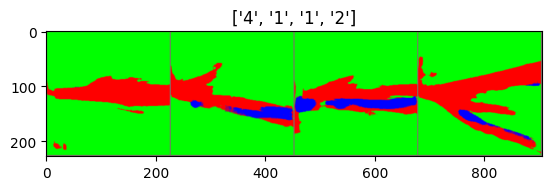

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(preds[j])
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [12]:
model_ft = models.mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2970 Acc: 0.5845
val Loss: 0.8621 Acc: 0.6679

Epoch 1/9
----------
train Loss: 0.7703 Acc: 0.7284
val Loss: 0.9894 Acc: 0.6768

Epoch 2/9
----------
train Loss: 0.4126 Acc: 0.8643
val Loss: 0.9219 Acc: 0.6793

Epoch 3/9
----------
train Loss: 0.3298 Acc: 0.8926
val Loss: 0.9982 Acc: 0.6717

Epoch 4/9
----------
train Loss: 0.2812 Acc: 0.9123
val Loss: 1.0022 Acc: 0.6755

Epoch 5/9
----------
train Loss: 0.2844 Acc: 0.9070
val Loss: 1.0645 Acc: 0.6591

Epoch 6/9
----------
train Loss: 0.2787 Acc: 0.9115
val Loss: 0.9921 Acc: 0.6692

Epoch 7/9
----------
train Loss: 0.2731 Acc: 0.9080
val Loss: 1.0034 Acc: 0.6984

Epoch 8/9
----------
train Loss: 0.2705 Acc: 0.9190
val Loss: 1.0038 Acc: 0.6743

Epoch 9/9
----------
train Loss: 0.2891 Acc: 0.9102
val Loss: 1.0367 Acc: 0.6540

Training complete in 9m 5s
Best val Acc: 0.698352


tensor(2, device='cuda:0')


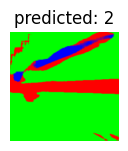

tensor(3, device='cuda:0')


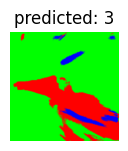

tensor(3, device='cuda:0')


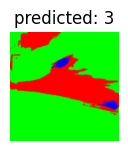

tensor(1, device='cuda:0')


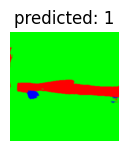

tensor(2, device='cuda:0')


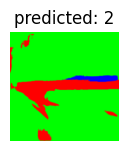

tensor(4, device='cuda:0')


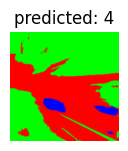

In [16]:
visualize_model(model_ft)

In [15]:
torch.save(model_ft, "/content/drive/MyDrive/Autonomous Driving/bev_classifier/weights_bevcam.pth")

In [ ]:
model_pt = torch.load("/content/drive/MyDrive/Autonomous Driving/bev_classifier/weights_bevcam.pth")

tensor(3, device='cuda:0')


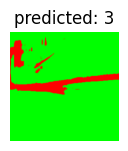

tensor(1, device='cuda:0')


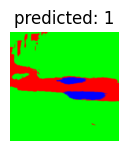

tensor(2, device='cuda:0')


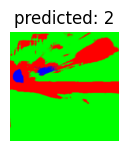

tensor(1, device='cuda:0')


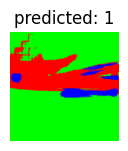

tensor(0, device='cuda:0')


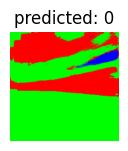

tensor(0, device='cuda:0')


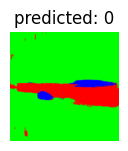

In [ ]:
visualize_model(model_pt)